In [2]:
# install packages in libs (as editable)
# !python -m pip install -e ../libs

# What is this notebook for ?

To analyze the results of the test run on owlv2 model
1. Merge the results with input data
2. Build and review confusion matrix
3. Look for few positive and negative results
4. Compare and contrast the predicted vs target

## Load input/target and results

In [1]:
from binsense.lightning.config import Config as TrainConfig

import pandas as pd

import os

experiment_run = 'test_baseline_v1'
cfg = TrainConfig()

inputs_fpath = os.path.join(cfg.data_csv_filepath)
inputs_df = pd.read_csv(inputs_fpath)
train_inputs_df = inputs_df.query('tag == "train"')
test_inputs_df = inputs_df.query('tag == "test"')

results_fpath = os.path.join(cfg.data_dirpath, f'testresults_{experiment_run}.csv')
results_df = pd.read_csv(results_fpath)

combined_df = test_inputs_df.merge(results_df, right_on="input_idx", how="inner", left_index=True)
print(combined_df.shape, inputs_df.shape, results_df.shape)

combined_df = combined_df[['query_label', 'image_relpath', 'count', 'bbox_coords', 'pred_boxes_count', 'pred_boxes_coords']]
combined_df.head()

(77, 8) (690, 5) (77, 3)


,query_label,image_relpath,count,bbox_coords,pred_boxes_count,pred_boxes_coords
0,B00KNK0M1O,filtered_dataset/test/images/109176.jpg,1,NaN,3,0.28697913885116577 0.02699633501470089 0.3590...
1,B01BLV4P6Q,filtered_dataset/test/images/111249.jpg,1,NaN,3,0.18574553728103638 0.2222900539636612 0.62931...
2,B00TX14HPQ,filtered_dataset/test/images/06972.jpg,1,NaN,36,0.8331282734870911 0.029354270547628403 0.3147...
3,B00AHXY10U,filtered_dataset/test/images/07067.jpg,1,NaN,8,0.48542240262031555 0.2004847228527069 0.98522...
4,B00KNK0M1O,filtered_dataset/test/images/109175.jpg,1,NaN,1,0.5042382478713989 0.47460418939590454 0.99218...


## Metrics and Confusion matrix 
Our query is if the bin has the required qty. We will look at these metrics.
- exists: (target count > 0 and pred count > 0) or (target count == 0 and pred count == 0)
- matches: target count == pred count

Additionaly to exactly match the query, we can simulate few queries with different count (say query_qty) and compute the below metric.
- meets: pred count > query_qty

exists accuracy =  80.52


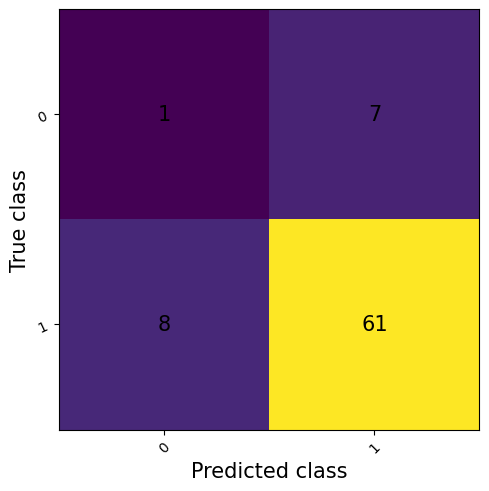

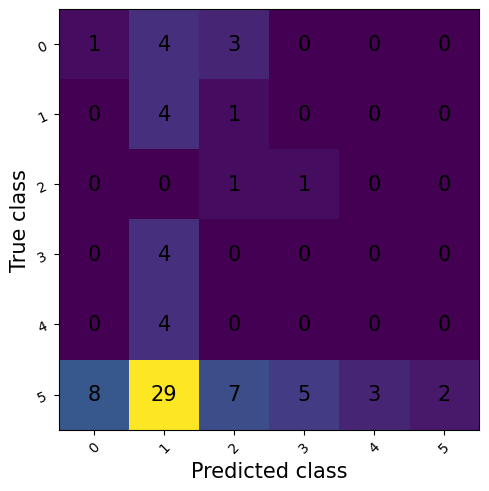

In [4]:
from torchmetrics import ConfusionMatrix
from matplotlib import pyplot as plt
import torch

# exists
gt = combined_df["count"].clip(0, 1, axis=0)
pred = combined_df["pred_boxes_count"].clip(0, 1, axis=0)
exists_acc = sum(gt == pred) / gt.shape[0]

exists_cmatrix = ConfusionMatrix(task="binary", num_classes=2)
exists_cmatrix(torch.as_tensor(gt.to_numpy()), torch.as_tensor(pred.to_numpy()))
print('exists accuracy = ', round(exists_acc * 100, 2))

exists_cmatrix.plot()
plt.show()


num_classes = 6
gt = combined_df["count"].clip(0, num_classes-1, axis=0)
pred = combined_df["pred_boxes_count"].clip(0, num_classes-1, axis=0)
matches_cmatrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
matches_cmatrix(torch.as_tensor(gt.to_numpy()), torch.as_tensor(pred.to_numpy()))
matches_cmatrix.plot()
plt.show()

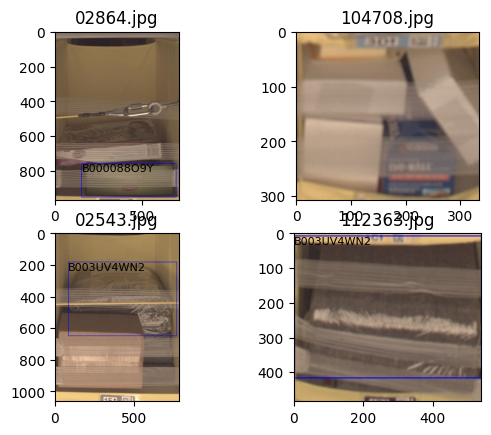

In [12]:
from binsense.img_utils import convert_cxy_xy_and_scale
from binsense.plot_utils import plot_bboxes
from matplotlib.pyplot import Axes

import numpy as np

import PIL

def to_pilimage(relpath):
    return PIL.Image.open(os.path.join(cfg.data_dirpath, relpath))

def draw_train_image(query_label, ax: Axes):
    trec = train_inputs_df[ (train_inputs_df['query_label'] == query_label) & (train_inputs_df['count'] > 0) ].iloc[0]
    
    img_pil = to_pilimage(trec['image_relpath'])
    plot_bboxes(
        cv_img=np.array(img_pil),
        bboxes=to_bboxes(trec['bbox_coords'], 1, (img_pil.width, img_pil.height)),
        labels=[query_label], ax=ax
    )
    ax.set_title(os.path.split(trec['image_relpath'])[1])

def draw_test_image(rec, ax: Axes, show_count=15):
    img_pil = to_pilimage(rec['image_relpath'])
    cnt = min(show_count, rec['pred_boxes_count'])
    if cnt > 0:
        bboxes = to_bboxes(rec['pred_boxes_coords'], cnt, (img_pil.width, img_pil.height))
        labels = [rec['query_label']] * cnt
    else:
        bboxes = []
        labels = []
    
    plot_bboxes(
        cv_img=np.array(img_pil),
        bboxes=bboxes,
        labels=labels, ax=ax
    )
    ax.set_title(os.path.split(rec['image_relpath'])[1])

def to_bboxes(bbox_coords, count, img_size):
    bboxes = []
    ccords = bbox_coords.split()
    for i in range(count):
        bbox = np.array([float(v) for v in ccords[i*4:i*4+4]])
        bboxes.append(bbox)
    
    return convert_cxy_xy_and_scale(np.array(bboxes), img_size)

tp_1 = combined_df.query('count == 0 & pred_boxes_count == 0').sample(1)
tp_2 = combined_df.query('count > 0 & pred_boxes_count > 0').sample(1)

fig, axs = plt.subplots(nrows=2, ncols=2)
draw_train_image(tp_1['query_label'].values[0], axs[0][0])
draw_test_image(tp_1.iloc[0], axs[0][1], show_count=0)

draw_train_image(tp_2['query_label'].values[0], axs[1][0])
draw_test_image(tp_2.iloc[0], axs[1][1], show_count=1)
plt.show()